# Importing Necessary Libraries

In [1]:
!pip install open3d
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import open3d as o3d
import glob
import os
import random
from os import listdir
from os.path import isfile, join
import sklearn

     |████████████████████████████████| 408.6 MB 21 kB/s 
     |████████████████████████████████| 3.1 MB 39.3 MB/s 
     |████████████████████████████████| 8.8 MB 28.1 MB/s 
     |████████████████████████████████| 1.1 MB 44.5 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 342 kB 42.2 MB/s 
     |████████████████████████████████| 428 kB 41.6 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 37.8 MB/s 
     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 130 kB 50.0 MB/s 
     |████████████████████████████████| 80 kB 7.3 MB/s 
     |████████████████████████████████| 561 kB 33.5 MB/s 
     |████████████████████████████████| 133 kB 53.3 MB/s 
  Created wheel for json5: filename=json5-0.9.8-py2.py3-none-any.whl size=18604 sha256=16db90bdd38dddb2d040a025b4b906a1d64ad9ca76806425c6cbd51d0e0b0ab1
  Stored in directory: /root/.cache/pip/wh

# Setting Random Seed

In [2]:
tf.random.set_seed(1234) # This just sets the global seed value for the sudo random generation


# Import ModelNet10 Dataset

In [3]:
modelnet = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)

473415680/473402300 [==============================] - 6s 0us/step


In [4]:
directory_name = os.path.dirname(modelnet)
Path_Dir = os.path.join(directory_name,'ModelNet10')
print(Path_Dir)


/root/.keras/datasets/ModelNet10


[[ 23.79236379  23.20217845   6.69290018]
 [ 25.37676896  22.0475502   -6.19573327]
 [ 23.9086446   22.0475502   -5.15674136]
 ...
 [-21.92085003 -21.67042486   9.05510044]
 [-16.76885911 -21.71460868   9.05510044]
 [-21.59099388 -19.24690659   9.05510044]]
(1024, 3)


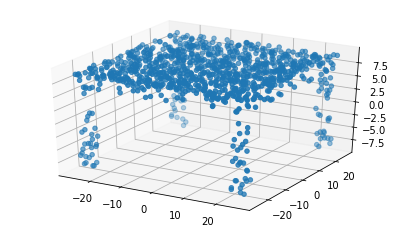

In [125]:
mesh = o3d.io.read_triangle_mesh(os.path.join(Path_Dir, "table/train/table_0001.off"))
points = mesh.sample_points_uniformly(1024)
points = np.array(points.points)

print(points)
print(points.shape)

x = []
y = []
z = []
for i in points:
  x.append(i[0])
  y.append(i[1])
  z.append(i[2])
fig = plt.figure(figsize=(7, 4))
# fig.add_subplot(2, 4, i + 1)
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z);
points = tf.reshape(points,(-1,1024,3))
points = tf.nn.l2_normalize(points, axis = (1,2))

# Iterate through ModelNet10 files and convert the 3D mesh into point cloud data

In [37]:
number_of_samples = 1024

#Let us define train/test data
train_data = []     # Training data
test_data = []      # Testing data
train_ID = []       # Training labels 
test_ID = []        # Testing labels

#Iterate over paths to classes
classes = ['toilet', 'table', 'bed', 'desk', 'dresser', 'chair', 'monitor', 'night_stand', 'bathtub', 'sofa']
path_to_class = []
count = 0

for i in classes: 
  path_to_class.append(os.path.join(Path_Dir,i))
  # training_files = glob.glob(os.path.join(path_to_class[count], "train/*"))
  # testing_files = glob.glob(os.path.join(path_to_class[count], "test/*"))

  train_alt = os.path.join(path_to_class[count], "train")
  test_alt  =  os.path.join(path_to_class[count], "test")

  train_list = [os.path.join(train_alt, _) for _ in os.listdir(train_alt) if _.endswith(".off")]
  test_list = [os.path.join(test_alt, _) for _ in os.listdir(test_alt) if _.endswith(".off")]


  #Let's now iterate over the training and test files to extract point cloud data from the 3D mesh
  for j in train_list:
    train_data.append(o3d.io.read_triangle_mesh(j).sample_points_uniformly(number_of_samples).points)
    train_ID.append(count)
    
  for k in test_list:
    test_data.append(o3d.io.read_triangle_mesh(k).sample_points_uniformly(number_of_samples).points)
    test_ID.append(count)

  count += 1



In [38]:
# Convert training/testing data into numpy arrays for convenience
train_data = np.array(train_data)
train_ID = np.array(train_ID)
test_data = np.array(test_data)
test_ID = np.array(test_ID)

# Now we have everything as point cloud data, but before feeding this to the PointNet architecture, let's re-organize the data so that the inner structure of the data can be learned better

In [39]:
size_of_batch = 32

# Shuffle training & test data
index_list_train = tf.range(start=0, limit=train_data.shape[0])
index_list_test = tf.range(start=0, limit=test_data.shape[0])

shuffled_index_list_train = tf.random.shuffle(index_list_train)
shuffled_index_list_test = tf.random.shuffle(index_list_test)

train_data = tf.gather(train_data, shuffled_index_list_train)
test_data = tf.gather(test_data, shuffled_index_list_test)

# Jitter 
train_data += tf.random.uniform(train_data.shape, -0.006, 0.006, dtype=tf.float64)

# Normalize 
train_data = tf.nn.l2_normalize(train_data, axis = (1,2))
test_data = tf.nn.l2_normalize(test_data, axis = (1,2))

train_ID = tf.gather(train_ID, shuffled_index_list_train)
test_ID = tf.gather(test_ID, shuffled_index_list_test)

# Bring together data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_ID))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_ID))
train_dataset = train_dataset.shuffle(len(train_data)).batch(size_of_batch)
test_dataset = test_dataset.shuffle(len(test_data)).batch(size_of_batch)

#Let's start building the Network
# 1.) Input transform 

In [40]:
# The paper uses a constraint on the feature transformation, such that the feature transformation is close to orthogonal. 
# The regularizer that they use to achieve this is: L = ||I-AA'||^2 where A is tyher feature alignment matrix
# predicted by the mini-network 
# Thus, we must define this regularizer:
class regularizaer_constraint(keras.regularizers.Regularizer):
    def __init__(self, Feature_Matrix_Size):
        self.Feature_Matrix_Size = Feature_Matrix_Size

    def __call__(self, x):
        weight = 0.001
        A = tf.reshape(x, (-1, self.Feature_Matrix_Size, self.Feature_Matrix_Size))
        AA_T = tf.tensordot(A, A, axes=(2, 2))
        AA_T = tf.reshape(AA_T, (-1, self.Feature_Matrix_Size, self.Feature_Matrix_Size))
        eye = tf.eye(self.Feature_Matrix_Size)
        eye = tf.dtypes.cast(eye, dtype=tf.float64)
        AA_T  = tf.dtypes.cast(AA_T , dtype=tf.float64)
        reg = tf.square(AA_T-eye)
        reg = tf.reshape(reg, (-1,self.Feature_Matrix_Size, self.Feature_Matrix_Size))
        final_reg = tf.reduce_sum(weight * reg)
        return final_reg
    def get_config(self):
      return {"Feature_Matrix_Size": self.Feature_Matrix_Size}
      
    @classmethod
    def from_config(cls, config):
        return cls(**config)
   




# Mini Transformation Network (32 --> 64 --> 512 --> max pool --> 256 --> 128 --> Feature Matrix Size)

In [41]:
# Convolutional Layer (convolution --> batch normalization --> ReLu activation)
def T_Net(Point_Cloud_Data, Feature_Matrix_Size):

  #######
  bias = keras.initializers.Constant(np.eye(Feature_Matrix_Size).flatten())
  #######

  # define regularizer
  R = regularizaer_constraint(Feature_Matrix_Size)   

  # Shared MLP (32,64,512)
  y = tf.keras.layers.Conv1D(32,kernel_size = 1, padding = "valid")(Point_Cloud_Data)
  y = tf.keras.layers.BatchNormalization(momentum=0.0)(y)
  y = tf.keras.layers.Activation("relu")(y)
      
  y = tf.keras.layers.Conv1D(64,kernel_size = 1, padding = "valid")(y)
  y = tf.keras.layers.BatchNormalization(momentum=0.0)(y)
  y = tf.keras.layers.Activation("relu")(y)

  y = tf.keras.layers.Conv1D(512,kernel_size = 1, padding = "valid")(y)
  y = tf.keras.layers.BatchNormalization(momentum=0.0)(y)
  y = tf.keras.layers.Activation("relu")(y)

  # Max Pooling 
  y = tf.keras.layers.GlobalMaxPooling1D()(y)

  # MLP(256,128,Feature_Matrix_Size)
  y = tf.keras.layers.Dense(256)(y)
  y = tf.keras.layers.BatchNormalization(momentum=0.0)(y)
  y = tf.keras.layers.Activation("relu")(y)

  y = tf.keras.layers.Dense(128)(y)
  y = tf.keras.layers.BatchNormalization(momentum=0.0)(y)
  y = tf.keras.layers.Activation("relu")(y)

  output_length =  Feature_Matrix_Size*Feature_Matrix_Size
  y = tf.keras.layers.Dense(output_length, kernel_initializer="zeros", bias_initializer=bias, activity_regularizer=R)(y)

  transformation_matrix = tf.keras.layers.Reshape((Feature_Matrix_Size,Feature_Matrix_Size))(y)

  # Multiply Point Cloud Data point inputs by transformation matrix:
  transformed_input = tf.keras.layers.Dot(axes=(2, 1))([Point_Cloud_Data,transformation_matrix])

  return transformed_input

#Awesome, now we can move on to defining the rest of the classification network

# Main Network: (input --> 32 --> 32 --> Tnet(32) --> 32 --> 64 --> 512 --> Max Pooling --> 256 --> 128 --> Softmax for 10 classes)

In [42]:
# Initialize input size
PC_Data = tf.keras.Input(shape=(number_of_samples,3))

#Input Transform
p = T_Net(PC_Data,3)

# Shared MLP(64,64)

p = tf.keras.layers.Conv1D(32,kernel_size = 1, padding = "valid")(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

p = tf.keras.layers.Conv1D(32,kernel_size = 1, padding = "valid")(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

# Feature Transform
p = T_Net(p,32)

# Shared MLP(64,128,1024)
p = tf.keras.layers.Conv1D(32,kernel_size = 1, padding = "valid")(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

p = tf.keras.layers.Conv1D(64,kernel_size = 1, padding = "valid")(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

p = tf.keras.layers.Conv1D(512,kernel_size = 1, padding = "valid")(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

# Now apply max pooling 
p = tf.keras.layers.GlobalMaxPooling1D()(p)

# MLP(512,256,k)
p = tf.keras.layers.Dense(256)(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

#Dropout with keep ratio: 0.7
p = tf.keras.layers.Dropout(0.3)(p)

p = tf.keras.layers.Dense(128)(p)
p = tf.keras.layers.BatchNormalization(momentum=0.0)(p)
p = tf.keras.layers.Activation("relu")(p)

#Dropout with keep ratio: 0.7
p = tf.keras.layers.Dropout(0.3)(p)


output_scores = tf.keras.layers.Dense(10, activation="softmax")(p)

PointNet_Architecture = tf.keras.Model(inputs=PC_Data, outputs=output_scores)
PointNet_Architecture.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1024, 32)     0           ['batch_normalization[0][0]']

In [43]:
PointNet_Architecture = tf.keras.Model(inputs=PC_Data, outputs=output_scores)
PointNet_Architecture.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1024, 32)     0           ['batch_normalization[0][0]

# Time to Train

In [44]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
PointNet_Architecture.compile(loss="sparse_categorical_crossentropy",optimizer=opt, metrics=["sparse_categorical_accuracy"])
print()
history = PointNet_Architecture.fit(train_dataset, epochs=50, validation_data=test_dataset)


Epoch 1/50
125/125 [==============================] - 259s 2s/step - loss: 2.0733 - sparse_categorical_accuracy: 0.7479 - val_loss: 2.1183 - val_sparse_categorical_accuracy: 0.7280
Epoch 2/50
125/125 [==============================] - 243s 2s/step - loss: 1.6353 - sparse_categorical_accuracy: 0.8459 - val_loss: 1.6147 - val_sparse_categorical_accuracy: 0.7996
Epoch 3/50
125/125 [==============================] - 226s 2s/step - loss: 1.4646 - sparse_categorical_accuracy: 0.8970 - val_loss: 1.6637 - val_sparse_categorical_accuracy: 0.8304
Epoch 4/50
125/125 [==============================] - 232s 2s/step - loss: 1.4686 - sparse_categorical_accuracy: 0.8980 - val_loss: 1.5443 - val_sparse_categorical_accuracy: 0.8480
Epoch 5/50
125/125 [==============================] - 231s 2s/step - loss: 1.4268 - sparse_categorical_accuracy: 0.9068 - val_loss: 1.9193 - val_sparse_categorical_accuracy: 0.7896
Epoch 6/50
125/125 [==============================] - 230s 2s/step - loss: 1.4028 - sparse_cat

# Visulize Loss

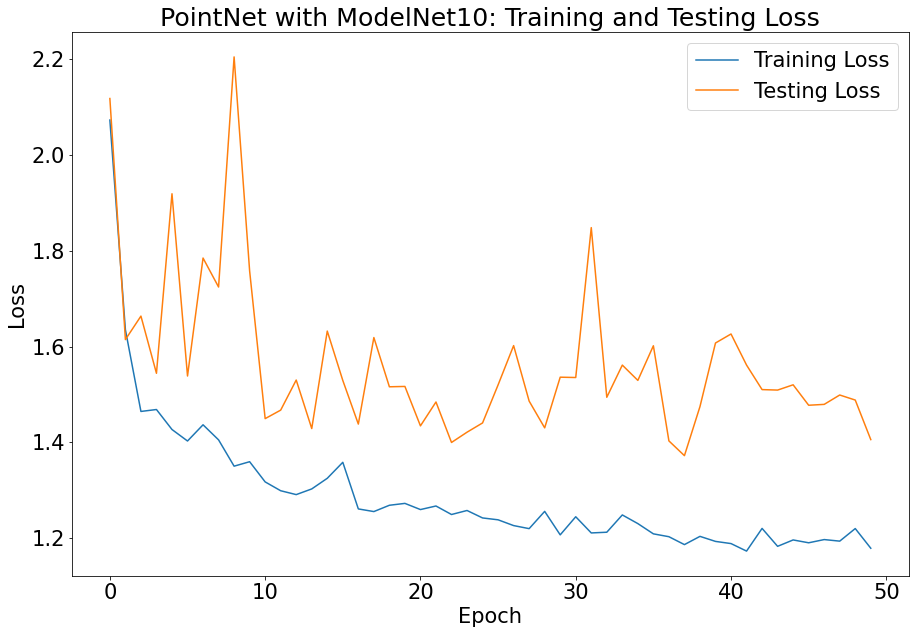

In [53]:
# Loss
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 21})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('PointNet with ModelNet10: Training and Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

# Prediction on Test Data

In [46]:
test_prediction = PointNet_Architecture.predict(test_data)
test_prediction = tf.math.argmax(test_prediction, -1)
test_prediction = np.array(test_prediction)

In [91]:
acc = tf.keras.metrics.Accuracy()
acc.update_state(test_ID,test_prediction)
accuracy = np.array(acc.result())
print("Accuracy: " + str(accuracy))

Accuracy: 0.8964758


In [86]:
# F1 score for test data 
f1 = sklearn.metrics.f1_score(test_ID,test_prediction,average='weighted')
print("F1 Score: " + str(f1))

F1 Score: 0.8954897550752172


#Visualizing Classification Results

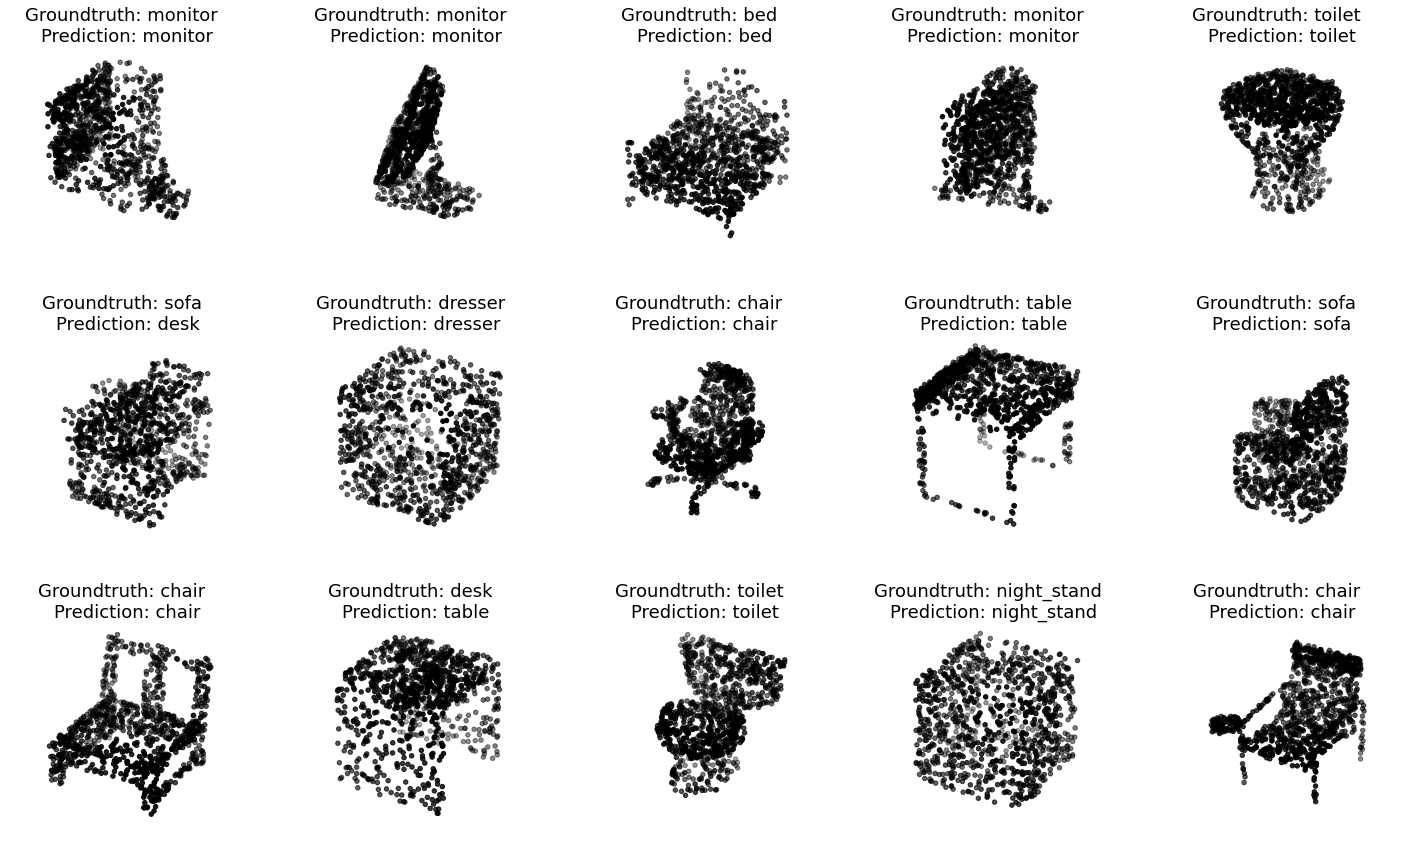

In [92]:
classes = ['toilet', 'table', 'bed', 'desk', 'dresser', 'chair', 'monitor', 'night_stand', 'bathtub', 'sofa']
N = 15
fig = plt.figure(figsize=(25, 15))
for i in range(N):
  points = np.array(test_data[i])
  x = []
  y = []
  z = []
  for j in points:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])
  ax = fig.add_subplot(3, 5, i + 1, projection="3d")
  ax.scatter3D(x, y, z,color='black')
  plt.rcParams.update({'font.size': 15})
  ax.set_title("Groundtruth: " + str(classes[test_prediction[i]])  + "  \nPrediction: " + str(classes[test_ID[i]]))
  ax.set_axis_off()
plt.show()

# Optional: Mount Google Drive and Save Model for future access

In [83]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [84]:
Pointnet = 'PointNet_Newest'
path = F"/content/gdrive/My Drive/{Pointnet}" 
PointNet_Architecture.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/PointNet_Newest/assets


INFO - 2022-05-21 22:40:17,801 - builder_impl - Assets written to: /content/gdrive/My Drive/PointNet_Newest/assets


# Prediction using Loaded Model on STL files found on Thingiverse

#Load saved Model

In [93]:
model = keras.models.load_model("/content/gdrive/MyDrive/PointNet", custom_objects={"regularizaer_constraint": regularizaer_constraint})

# Iterate through STL files and convert to 
# NOTE: You must change path if you would like to run this part 

In [94]:
stl_path = "/content/gdrive/MyDrive/stlupdate2" #CHANGE THIS

# stl_path = os.path.dirname(r"/content/gdrive/MyDrive/Bathtub")
classes = ['toilet', 'table', 'bed', 'desk', 'dresser', 'chair', 'monitor', 'night_stand', 'bathtub', 'sofa']
stl_points = []
path_to_class = []
alt = [] #alternative 
class_num = []
K = 10

# for z in range(K):
#   stl_points.append([] * K)

count = 0
for i in classes: 
  path_to_class.append(os.path.join(stl_path,i))
  dir_list = os.listdir(path_to_class[count])
  for j in dir_list: 
    object_mesh = os.path.join(path_to_class[count],j)
    point_cloud = o3d.io.read_triangle_mesh(object_mesh).sample_points_uniformly(1024).points
    stl_points.append(point_cloud)
    class_num.append(count)

  count +=1

stl_points = np.array(stl_points)
stl_points = tf.nn.l2_normalize(stl_points, axis = (1,2))

#Predictions for online CAD Model classification

In [95]:
stl_prediction = model.predict(stl_points)
stl_prediction = tf.math.argmax(stl_prediction, -1)
stl_prediction = np.array(stl_prediction)
print(stl_prediction)

[1 8 1 1 6 5 1 1 1 1 1 5 1 1 1 1 5 0 1 2 2 2 2 5 2 1 5 1 5 0 5 1 5 2 1 1 2
 1 5 6 5 5 2 1 1 2 1 6 5 5 1 1 8 5 5 1 1 1 5 5 0 1 7 5 0 0 1 5 5 2 6 5 5 1
 8 1 5 1 0 1 5 5 5 5 1 5]


In [96]:
acc = tf.keras.metrics.Accuracy()
acc.update_state(class_num,stl_prediction)
stl_acc = acc.result().numpy
print("Accuracy: " + str(stl_acc))

Accuracy: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.23255815>>


In [98]:
# F1 score for cad models
f1 = sklearn.metrics.f1_score(class_num,stl_prediction,average='weighted')
print("F1 Score: " + str(f1))

F1 Score: 0.1666648596881155


#Predictions for test set classification

In [99]:
test_prediction = model.predict(test_data)
test_prediction = tf.math.argmax(test_prediction, -1)
test_prediction = np.array(test_prediction)

In [100]:
acc = tf.keras.metrics.Accuracy()
acc.update_state(test_ID,test_prediction)
test_acc = acc.result().numpy
print("Accuracy: " + str(test_acc))

Accuracy: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.89096916>>


In [102]:
# F1 score for test data 
f1 = sklearn.metrics.f1_score(test_ID,test_prediction,average='weighted')
print("F1 Score: " + str(f1))

F1 Score: 0.8890517253539979
